### 1. Подготовка данных

In [1]:
# загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
from warnings import simplefilter 
import optuna
from scipy.stats import uniform

In [2]:
# Загрузим данные и выведем первых 5 строк
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Т.к. в задании сказано, что чредварительная обработка не требуется, данные уже закодированы и нормализованы посмотрим сразу на сбалансированность классов 

1    0.542255
0    0.457745
Name: Activity, dtype: float64

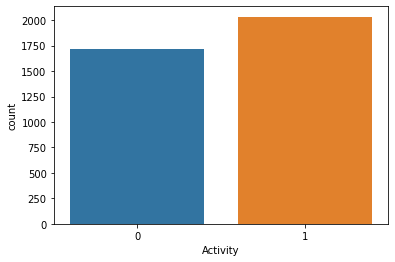

In [3]:
display(data['Activity'].value_counts(normalize=True))
sns.countplot(data=data, x='Activity');

Видим что данные сбалансированы не плохо.

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака использование параметра stratify не обязательно, т.к. выборки сбалансированы. И посмотрим как распеределились наши выборки

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2)
# посмотрим как распеределились наши выборки
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')

Train:
1    0.541667
0    0.458333
Name: Activity, dtype: float64
Valid:
1    0.544607
0    0.455393
Name: Activity, dtype: float64


### 2. Базовые модели
Строим базовые модели с параметрами по умолчанию. Классы взвешены.

**Cначала посчитаем модель с параметрами по умолчанию и оценим метрику**

In [6]:
# Логистическая регрессии с параметрами по умолчанию

#Создаем объект класса логистическая регрессия
log_reg = LogisticRegression(n_jobs=-1, random_state=42, max_iter=50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print("f1_score на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 0.88
f1_score на тестовом наборе: 0.78


In [7]:
# Случайный лес

rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_train)
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

print("f1_score на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 1.00
f1_score на тестовом наборе: 0.82


### 3. Оптимизация гиперпараметров GridSearchCV

#### 3.1. Логистическая регрессия

In [10]:
%%time
# Подберем параметры для логистической регрессии способом GridSearchCV
# Сетка гиперпараметров
param_grid = [
    
    {'solver': ['saga'],
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.]},
                 
    {'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.]},
    
    {'solver': ['saga'],
    'penalty': ['none']},
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(n_jobs=2, random_state=42, max_iter=50), 
    param_grid=param_grid, 
    scoring = 'f1',
    cv=5, 
    n_jobs = 2
)  
grid_search_lr.fit(X_train, y_train) 
y_train_pred = grid_search_lr.predict(X_train)
y_test_pred = grid_search_lr.predict(X_test)

print("f1_score на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

f1_score на тренировочной выборке: 0.84
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 43 s


#### 3.2. Случайный лес

In [12]:
%%time
# Сетка параметров
param_grid = [
    
    {'n_estimators': [100, 200, 300],
     'criterion': ['gini', 'entropy'],
     'max_depth': [5, 10, 50],
     'min_samples_leaf': [5, 50]
    }
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(n_jobs=2, random_state=42), 
    param_grid=param_grid, 
    scoring = 'f1',
    cv=5, 
    n_jobs = 2
)  
grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)

print("f1 на тренировочной выборке: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

f1 на тренировочной выборке: 0.95
f1 на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 300}
Wall time: 1min 11s


### 4. Оптимизация гиперпараметров RandomizedSearchCV

#### 4.1. Логистическая регрессия

In [13]:
%%time
# Пространство параметров: создаем несколько словарей с наборами параметров, 
# Параметр регуляризации выбирается случайным образом из равномерного распределения
param_distr = [
    
    {'solver': ['saga'],
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0.01, scale=1)},
                 
    {'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': uniform(loc=0.01, scale=1)},
    
    {'solver': ['saga'],
    'penalty': ['none']},
]

# ignore all warnings
simplefilter(action='ignore')

# Случайный поиск по распределению параметров с кросс-валидацией (5 фолдов)
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=50, n_jobs = 2), 
    param_distributions=param_distr, 
    scoring = 'f1',
    cv=5,
    n_iter=20,  # 20 случайных наборов параметров
    n_jobs = 2
)  
random_search_lr.fit(X_train, y_train) 
y_train_pred = random_search_lr.predict(X_train)
y_test_pred = random_search_lr.predict(X_test)

print("f1 на кросс-валидации: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

f1 на кросс-валидации: 0.86
f1 на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'C': 0.10741975695591087, 'penalty': 'l2', 'solver': 'lbfgs'}
Wall time: 1min 27s


#### 4.2. Случайный лес

In [14]:
%%time
# Распределение параметров в виде сетки
param_distr = [
    
    {'n_estimators': list(range(100, 500, 100)),
     'criterion': ['gini', 'entropy'],
     'max_depth': list(range(1, 100, 5)),
     'min_samples_leaf': list(range(5, 100, 5))
    }
]

# Случайный поиск по распределению параметров с кросс-валидацией (5 фолдов)
random_search_rf = RandomizedSearchCV(
    estimator = RandomForestClassifier( n_jobs=2, random_state=42),
    param_distributions=param_distr, 
    scoring = 'f1',
    cv=5,
    n_iter=20, # 20 случайных наборов параметров
    n_jobs = 2
)  
random_search_rf.fit(X_train, y_train) 
y_train_pred = random_search_rf.predict(X_train)
y_test_pred = random_search_rf.predict(X_test)

print("f1 на кросс-валидации: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

f1 на кросс-валидации: 0.91
f1 на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 10, 'max_depth': 41, 'criterion': 'entropy'}
Wall time: 49.5 s


### 5. Оптимизация гиперпараметров Hyperopt

#### 5.1. Логистическая регрессия

In [15]:
%%time
# Параметр регуляризации выбирается случайным образом из равномерного распределения
space = hp.choice('parameter_combinations', [
        {'solver': 'saga',
         'penalty': hp.choice('penalty', ['l1', 'l2']),
         'C': hp.uniform('C_saga', 0.01, 1)
        },
        
        {'solver': 'lbfgs',
        'penalty': 'l2',
        'C': hp.uniform('C_lbfgs', 0.01, 1)
        }
        ]
)

random_state = 42

# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=42):
    params = {'solver': params['solver'], 
              'penalty': params['penalty'], 
              'C': params['C']
             }
      
    model = LogisticRegression(**params, class_weight='balanced', 
        random_state=random_state, max_iter=50
    )
      
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=2).mean()

    return -score 


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(random_state)
         )

print("Наилучшие значения гиперпараметров {}".format(best))

100%|████████████████████████████████████████████████| 20/20 [01:45<00:00,  5.28s/trial, best loss: -0.784115517074601]
Наилучшие значения гиперпараметров {'C_saga': 0.023051205281475296, 'parameter_combinations': 0, 'penalty': 1}
Wall time: 1min 45s


In [16]:
# Расчет метрики для лучших найденных гиперпараметров 

best_params = {'solver': 'saga',
          'penalty': 'l2', 
          'C': 0.023051205281475296
}

# Модель с лучшими параметрами
hyperopt_lr = LogisticRegression(**best_params, random_state=42, max_iter=50)
hyperopt_lr.fit(X_train, y_train)
y_train_pred = hyperopt_lr.predict(X_train)
y_test_pred = hyperopt_lr.predict(X_test)

In [17]:
best_score = (np.array(list(x['result']['loss'] 
                            for x in trials.trials)) * (-1)).max()

print(f'f1 на кросс-валидации: {best_score}')
print('f1 на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров {}'.format(best))

f1 на кросс-валидации: 0.784115517074601
f1 на тренировочной выборке: 0.83
f1 на тестовом наборе: 0.80
Наилучшие значения гиперпараметров {'C_saga': 0.023051205281475296, 'parameter_combinations': 0, 'penalty': 1}


#### 5.2. Случайный лес

In [18]:
%%time
# Пространство параметров 
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'criterion': hp.choice('criterion', ['gini', 'entropy']),
       'max_depth' : hp.quniform('max_depth', 1, 100, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 100, 1)
      }

random_state = 42
# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=42):
    params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf'])
             }
  
    model = RandomForestClassifier(**params, class_weight='balanced', 
                                   n_jobs=-1, random_state=random_state)
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=2).mean()
    
    return -score


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(random_state)
         )
print(f'Наилучшие значения гиперпараметров: {best}')

100%|███████████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/trial, best loss: -0.8124707056922034]
Наилучшие значения гиперпараметров: {'criterion': 0, 'max_depth': 85.0, 'min_samples_leaf': 3.0, 'n_estimators': 311.0}
Wall time: 1min 4s


In [19]:
# Расчет метрики для лучших найденных гиперпараметров 

best_score = (np.array(list(x['result']['loss'] 
                            for x in trials.trials)) * (-1)).max()
print(f'F1 на кросс-валидации: {best_score}')

best_params = {
    'n_estimators': int(best['n_estimators']),
    'criterion': 'gini',
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf'])
}

# Модель с лучшими параметрами
hyperopt_rf = RandomForestClassifier(**best_params, n_jobs=2, random_state=42)
hyperopt_rf.fit(X_train, y_train)
y_train_pred = hyperopt_rf.predict(X_train)
y_test_pred = hyperopt_rf.predict(X_test)

print('f1 на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 на кросс-валидации: 0.8124707056922034
f1 на тренировочной выборке: 0.98
f1 на тестовом наборе: 0.82


### 6. Оптимизация гиперпараметров Optuna

#### 6.1. Логистическая регрессия

In [24]:
%%time
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        class_weight='balanced', 
        random_state=42, 
        max_iter=50
    )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=2).mean()
    
    return score


# Поиск оптимальных гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами
optuna_lr = LogisticRegression(
    **study_lr.best_params, class_weight='balanced', n_jobs=-1,
    random_state=42, max_iter=50
)
optuna_lr.fit(X_train, y_train)
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

Wall time: 1min 29s


In [25]:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print(f'F1 на кросс-валидации: {round(study_lr.best_value,2)}')
print(f'F1 на тренировочной выборке: {round(f1_score(y_train, y_train_pred),2)}')
print(f'F1 на тестовой выборке: {round(f1_score(y_test, y_test_pred),2)}')

Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'C': 0.02464144483988132}
F1 на кросс-валидации: 0.78
F1 на тренировочной выборке: 0.83
F1 на тестовой выборке: 0.78


#### 6.2. Случайный лес

In [26]:
%%time
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 100, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, 1)
  
    # модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', n_jobs=2,
        random_state=42
    )
  
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=2).mean()
    
    return score


# Поиск оптимальных гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=42)
study_rf = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами  
optuna_rf = RandomForestClassifier(
    **study_rf.best_params, class_weight='balanced', n_jobs=-1,
    random_state=42
)
optuna_rf.fit(X_train, y_train)
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

Wall time: 1min 13s


In [27]:
print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')
print(f'F1 на кросс-валидации: {round(study_rf.best_value,2)}')
print(f'F1 на тренировочной выборке: {round(f1_score(y_train, y_train_pred),2)}')
print(f'F1 на тестовой выборке: {round(f1_score(y_test, y_test_pred),2)}')

Наилучшие значения гиперпараметров: {'n_estimators': 245, 'criterion': 'gini', 'max_depth': 78, 'min_samples_leaf': 2}
F1 на кросс-валидации: 0.81
F1 на тренировочной выборке: 0.99
F1 на тестовой выборке: 0.83
